# **Riiid! Answer Correctness Prediction**

## Imports

In [1]:
import numpy as np
import pandas as pd
import time


from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

## Functions

In [2]:
def print_filling_rate (data_df, a_label_abscisse, color_graphe, color_threshold  ) : 
    """ 
        Display the filling rate of the columns
        @donnees_df : dataframe qui contient les données
        @a_seuil : booléen égal à True si on souhaite afficher le seuil
        @a_label_abscisse : booléen égal à True si on souhaite afficher le nom des colonnes en abscisse
        @color_graphe
        @color_threshold 
    """
    if(color_graphe == ''):
        color_graphe = 'blue'
    data = (data_df.count() / len(data_df)).sort_values().values
    ind = np.arange(len(data))
    width = 0.5
    fig, axes = plt.subplots(1,1,figsize=(6, 3), dpi=100)
    tr = axes.bar(ind, data, width, color=color_graphe)
    axes.set_ylabel('Filling rates');
    if(a_label_abscisse):
        axes.set_xticks(ind )
        axes.set_xticklabels((data_df.count() / len(data_df)).sort_values().index, fontsize=10, rotation=90)
        axes.legend([tr], ['Filling rates'])
        

def print_pie(data_df, column, title_fig, title_legend) :
    """
    @data_df : data
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    #colors = ['blue','orange', 'green',  'pink', 'blue', 'teal',  'olive',    'deepskyblue',  'slategray',  'rebeccapurple',   'rosybrown','indianred','goldenrod','gold', 'khaki']
    ttl = plt.title(title_fig, fontsize=15, weight="bold")
    ttl.set_position([0, 1.05])
    data_df[column].value_counts(normalize=True).sort_index().plot(kind='pie', startangle=180, counterclock = False, autopct='%1.1f%%', fontsize = 14) #labels =labels, 
    plt.axis('equal')
    plt.ylabel('')
    plt.rcParams['legend.title_fontsize'] = 'large'
    ax.legend(title=title_legend, loc="center right",  bbox_to_anchor=(1, 0, 1, 1), fontsize='medium') #labels,
    plt.show()
        
        

## Data loading

We will follow this tutorials : [Competition API Detailed Introduction](https://www.kaggle.com/sohier/competition-api-detailed-introduction) and 
[Tutorial on reading large datasets](http://https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/).

In [3]:
%%time

questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 16.4 ms, sys: 4.09 ms, total: 20.5 ms
Wall time: 24.1 ms


In [4]:
%%time

dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', 
                       low_memory=False, 
                       nrows=10**6, 
                       dtype=dtypes
                      )
print("Train size:", train_df.shape)

Train size: (1000000, 10)
CPU times: user 1.67 s, sys: 306 ms, total: 1.98 s
Wall time: 2.05 s


In [5]:
train_df.memory_usage(deep=True)

Index                                 128
row_id                            8000000
timestamp                         8000000
user_id                           4000000
content_id                        2000000
content_type_id                   1000000
task_container_id                 2000000
user_answer                       1000000
answered_correctly                1000000
prior_question_elapsed_time       4000000
prior_question_had_explanation    2000000
dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int16  
 6   user_answer                     1000000 non-null  int8   
 7   answered_correctly              1000000 non-null  int8   
 8   prior_question_elapsed_time     976277 non-null   float32
 9   prior_question_had_explanation  996184 non-null   boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 31.5 MB


In [7]:
train_df.head(4)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False


In [8]:
train_df.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,976277.000000
mean,499999.500000,7.344311e+09,1.017255e+07,5232.691523,0.019907,806.105689,1.374784,0.617504,25319.472656
std,288675.278933,1.058693e+10,6.029234e+06,3882.323419,0.139681,1025.887530,1.194168,0.525364,19707.429688
min,0.000000,0.000000e+00,1.150000e+02,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,249999.750000,5.211669e+08,4.702585e+06,2057.000000,0.000000,109.000000,0.000000,0.000000,16000.000000
50%,499999.500000,2.824811e+09,9.678259e+06,5052.000000,0.000000,391.000000,1.000000,1.000000,21000.000000
75%,749999.250000,1.010186e+10,1.556872e+07,7421.000000,0.000000,1112.000000,3.000000,1.000000,29666.000000
max,999999.000000,7.809200e+10,2.094902e+07,32736.000000,1.000000,7739.000000,3.000000,1.000000,300000.000000


In [9]:
print("The dataset contains {} rows and {} columns. \n".format(train_df.shape[0], train_df.shape[0]))
for col in train_df:
    print("The column {} has {} unique values.".format(col, train_df[col].nunique()))

The dataset contains 1000000 rows and 1000000 columns. 

The column row_id has 1000000 unique values.
The column timestamp has 769357 unique values.
The column user_id has 3824 unique values.
The column content_id has 13320 unique values.
The column content_type_id has 2 unique values.
The column task_container_id has 7740 unique values.
The column user_answer has 5 unique values.
The column answered_correctly has 3 unique values.
The column prior_question_elapsed_time has 1659 unique values.
The column prior_question_had_explanation has 2 unique values.


row_id                                0
timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       23723
prior_question_had_explanation     3816
dtype: int64
****************************************
row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       0.023723
prior_question_had_explanation    0.003816
dtype: float64


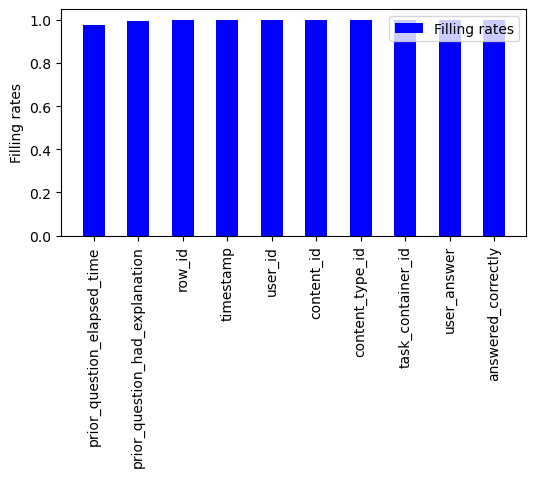

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(train_df.isnull().sum())
print("****************************************")
print(train_df.isnull().sum() / len(train_df))

print_filling_rate (train_df, True, "blue", "blue")

## Categorical variables :
* content_type_id
* user_answer
* answered_correctly **(TARGET)**

### content_type_id

In [11]:
train_df.content_type_id.value_counts()

0    980093
1     19907
Name: content_type_id, dtype: int64

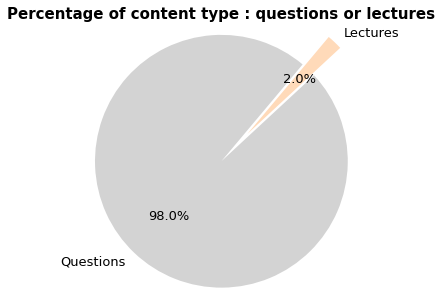

   content_type_id
0           980093
1            19907


In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Percentage of content type : questions or lectures', fontsize=15, weight="bold")
labels = ['Questions','Lectures']
colors = ['lightgray','peachpuff']
explode=(0.1,0.2 )
train_df["content_type_id"].value_counts(normalize=True).plot(kind='pie', labels=labels, colors=colors, explode=explode, startangle=50, autopct='%1.1f%%', fontsize = 13)
plt.axis('equal') 
plt.ylabel('')
plt.show()

print(train_df['content_type_id'].value_counts().sort_index().to_frame())

### user_answer

In [13]:
train_df.user_answer.value_counts()

 0    278205
 1    267017
 3    257932
 2    176939
-1     19907
Name: user_answer, dtype: int64

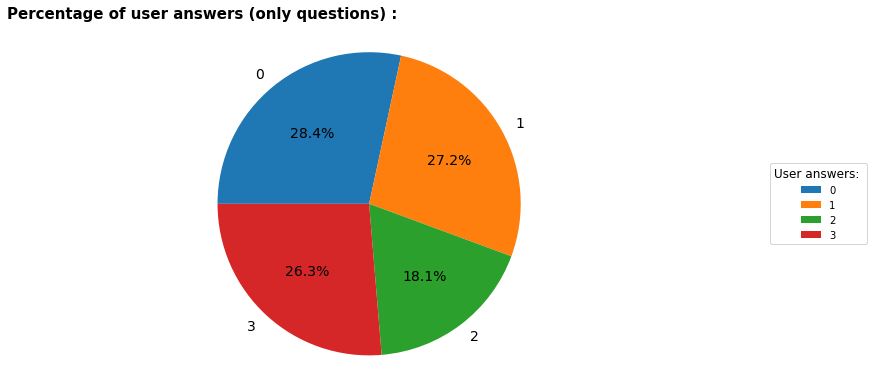

In [14]:
print_pie(train_df[train_df['user_answer']>=0], 'user_answer', "Percentage of user answers (only questions) :", "User answers: ")

## **answered_correctly = TARGET**

In [15]:
train_df.answered_correctly.value_counts()

 1    637411
 0    342682
-1     19907
Name: answered_correctly, dtype: int64

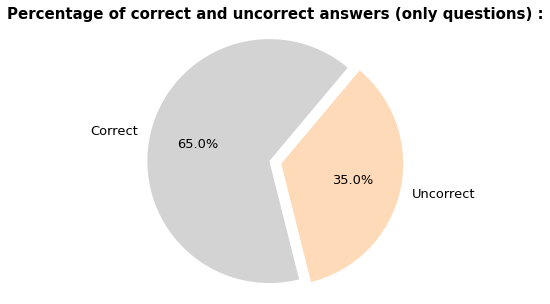

   answered_correctly
0              342682
1              637411


In [16]:
# print_pie(train_df[train_df['answered_correctly']>=0], 'answered_correctly', "User answered correctly ? :", "Answered correctly : ")
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Percentage of correct and uncorrect answers (only questions) :', fontsize=15, weight="bold")
labels = ['Correct', 'Uncorrect']
colors = ['lightgray','peachpuff']
explode=(0.1,0)
train_df[train_df['answered_correctly']>=0]["answered_correctly"].value_counts(normalize=True).plot(kind='pie', labels=labels, colors=colors, explode=explode, startangle=50, autopct='%1.1f%%', fontsize = 13)
plt.axis('equal') 
plt.ylabel('')
plt.show()

print(train_df[train_df['answered_correctly']>=0]['answered_correctly'].value_counts().sort_index().to_frame())

### 'prior_question_had_explanation' (boolean)

In [17]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df.loc[train_df["prior_question_had_explanation"]== True, "prior_had_explanation_le"] = 1
train_df.loc[train_df["prior_question_had_explanation"]== False, "prior_had_explanation_le"] = 0

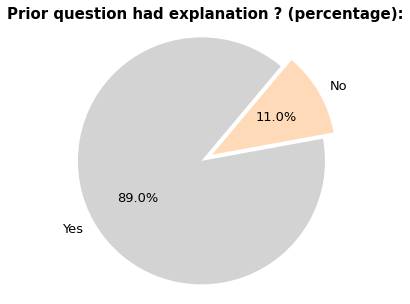

     prior_had_explanation_le
0.0                    110113
1.0                    889887


In [18]:
# print_pie(train_df[train_df['answered_correctly']>=0], 'answered_correctly', "User answered correctly ? :", "Answered correctly : ")
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Prior question had explanation ? (percentage):', fontsize=15, weight="bold")
labels = ['Yes', 'No']
colors = ['lightgray','peachpuff']
explode=(0.1,0)
train_df["prior_had_explanation_le"].value_counts(normalize=True).plot(kind='pie', labels=labels, colors=colors, explode=explode, startangle=50, autopct='%1.1f%%', fontsize = 13)
plt.axis('equal') 
plt.ylabel('')
plt.show()

print(train_df['prior_had_explanation_le'].value_counts().sort_index().to_frame())

## Continue variables :
* timestamp (Time variables milliseconds)
* prior_question_elapsed_time (Time variables milliseconds)

### timestamp

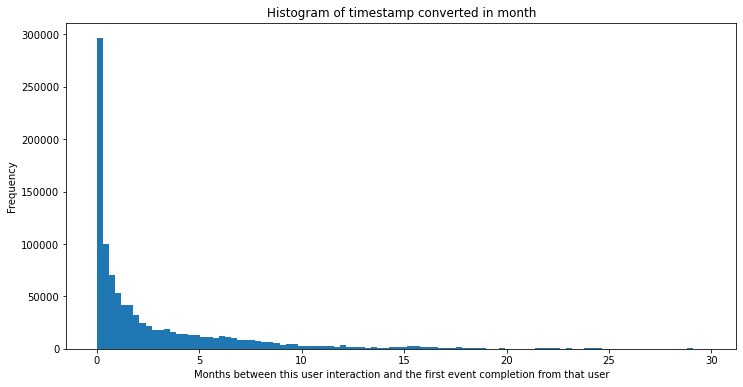

In [19]:
nbMillisecByYear = 1000 * 60 * 60 * 24 * 365
nbMillisecByMonth = nbMillisecByYear / 12
train_df['timestamp_by_month'] = train_df['timestamp']/nbMillisecByMonth
fig = plt.figure(figsize=(12,6))
train_df['timestamp_by_month'].plot.hist(bins=100)
plt.title("Histogram of timestamp converted in month")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

In [20]:
train_df = train_df[train_df['timestamp_by_month'] < 25]

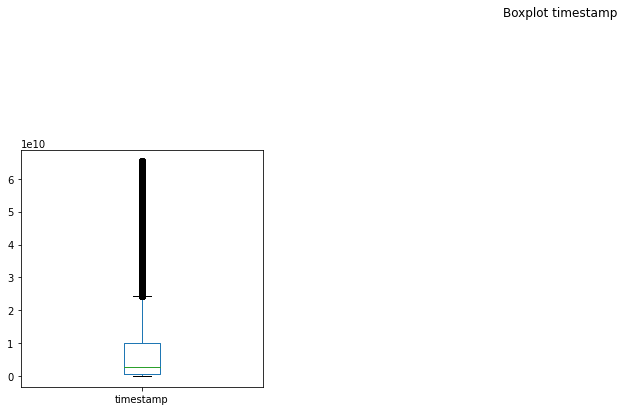

In [21]:
train_df['timestamp'].plot(kind='box', subplots=True, title='Boxplot timestamp', figsize=(20,20), layout=(4,4))
plt.show()

### prior_question_elapsed_time

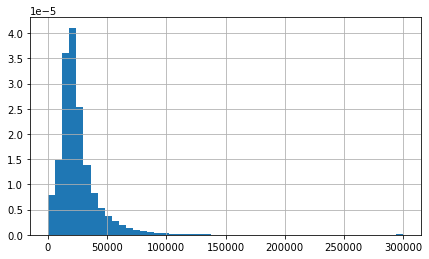

In [22]:
train_df['prior_question_elapsed_time'].hist(figsize=(7,4), density=True, bins= 50)
plt.show()

In [23]:
train_df['prior_question_elapsed_time_in_hours'] = train_df['prior_question_elapsed_time']/1000/60/60

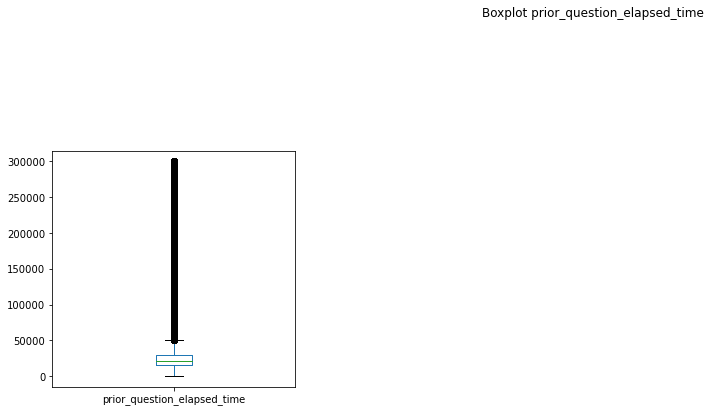

In [24]:
train_df['prior_question_elapsed_time'].plot(kind='box', subplots=True, title='Boxplot prior_question_elapsed_time', figsize=(20,20), layout=(4,4))
plt.show()

In [25]:
prior_question_elapsed_time_mean = train_df[~train_df['prior_question_elapsed_time'].isna()]['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

In [26]:
train_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'prior_had_explanation_le', 'timestamp_by_month',
       'prior_question_elapsed_time_in_hours'],
      dtype='object')

### Correlation

In [27]:
list_columns_corr = ['timestamp', 'user_id', 'content_id', 
                     'task_container_id', 'user_answer', 'answered_correctly',
                     'prior_question_elapsed_time', 'prior_question_had_explanation']

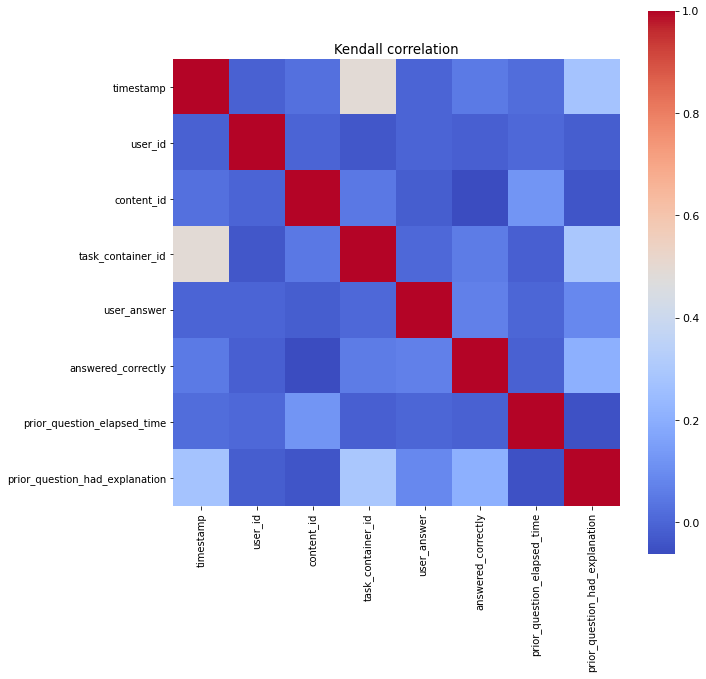

In [28]:
corr = train_df[~(train_df['prior_question_elapsed_time'].isna())][list_columns_corr].corr(method = "kendall")
f, ax = plt.subplots(figsize=(10, 10))
plt.rcParams['font.size'] = 11
ax.set_title('Kendall correlation')

#A1 = ['Calories','Mat. grasse','M.G.saturée','Glucides','Sucre','Fibres','Protéines','Sel','Sodium']

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), fmt=".2f", cmap='coolwarm', square=True, ax=ax ) #, xticklabels=A1, yticklabels=A1 )

## questions.csv

In [29]:
questions_df[questions_df['tags'].isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [30]:
questions_df.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


In [31]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64
****************************************
question_id       0.000000
bundle_id         0.000000
correct_answer    0.000000
part              0.000000
tags              0.000001
dtype: float64


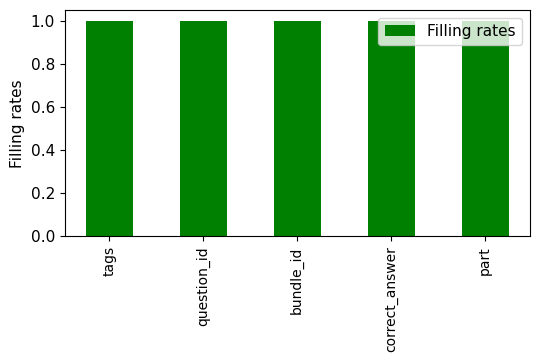

In [32]:
print(questions_df.isnull().sum())
print("****************************************")
print(questions_df.isnull().sum() / len(train_df))

print_filling_rate (questions_df, True, "green", "green")

In [33]:
questions_df['tags'].fillna("", inplace=True)
questions_df["nb_tags"] = questions_df["tags"].apply(lambda text: len(text.split()))

questions_df[questions_df['question_id'] == 10033]

,question_id,bundle_id,correct_answer,part,tags,nb_tags
10033,10033,10033,2,6,,0


In [34]:
questions_df = questions_df[questions_df["nb_tags"] > 0]

In [35]:
test = "".split()
len(test)

0

In [36]:
print('Le nombre max de tags par question : {}'.format(max(questions_df['nb_tags'])))
print('Le nombre min de tag par question : {}'.format(min(questions_df['nb_tags'])))
print('Le nombre moyen de tags par question : %f'%(sum(questions_df['nb_tags'])/len(questions_df['nb_tags'])))

Le nombre max de tags par question : 6
Le nombre min de tag par question : 1
Le nombre moyen de tags par question : 2.291969


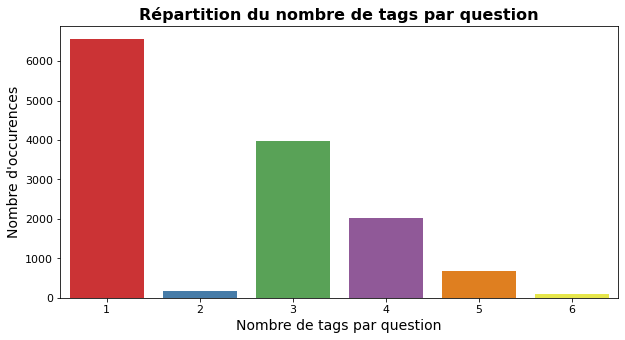

In [37]:
import matplotlib.style as style
style.use('seaborn-dark-palette')
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Répartition du nombre de tags par question", fontsize=16, weight="bold");

sns.countplot(questions_df['nb_tags'], palette="Set1")
ax.set_ylabel("Nombre d'occurences", fontsize=14)
ax.set_xlabel("Nombre de tags par question", fontsize=14);

In [38]:
'''tags = questions_df[~questions_df['tags'].isna()]['tags']



list_tags = []
list_unique_tags = []

def create_lists_tags(text) :
    text_list = text.split()
    for i in range(0,len(text_list)):
        list_unique_tags.append(text_list[i])
        if(text_list[i] not in list_unique_tags) :
            list_unique_tags.append(text_list[i])

tags.apply(lambda text: create_list_unique_tags(text))

len(list_unique_tags)'''

"tags = questions_df[~questions_df['tags'].isna()]['tags']\n\n\n\nlist_tags = []\nlist_unique_tags = []\n\ndef create_lists_tags(text) :\n    text_list = text.split()\n    for i in range(0,len(text_list)):\n        list_unique_tags.append(text_list[i])\n        if(text_list[i] not in list_unique_tags) :\n            list_unique_tags.append(text_list[i])\n\ntags.apply(lambda text: create_list_unique_tags(text))\n\nlen(list_unique_tags)"

In [39]:
questions_df['tags_list'] = questions_df['tags'].apply(lambda x: x.split())
tags_list = [item for sublist in questions_df['tags_list'].values for item in sublist]
print(len(tags_list))
tags_unique_list = list(set(tags_list))
# Affiche la nouvelle liste 
print(len(tags_unique_list))

30992
188


In [40]:
import nltk
def distribution_nb_apparition_tag_questions(nb_tags, title, with_return):
    tags_most_common = tags_frequence.most_common(nb_tags)
    tags_df = pd.DataFrame(tags_most_common, columns = ['tags' , 'nb_tags']) 
    tags_df.columns
    tags_sorted_df = tags_df.sort_values(['nb_tags'], ascending=False)
    tags_counts = tags_sorted_df['nb_tags'].values
    plt.plot(tags_counts)
    plt.title(title)
    plt.grid()
    plt.xlabel("Nombre de tags")
    plt.ylabel("Nombre d'occurences")
    plt.show()
    if(with_return):
        return tags_df

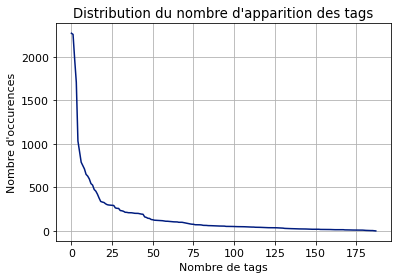

In [41]:
tags_frequence= nltk.FreqDist(tags_list)



tags_df = distribution_nb_apparition_tag_questions(len(tags_unique_list), "Distribution du nombre d'apparition des tags", True)

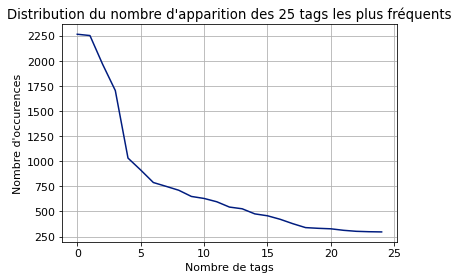

In [42]:
distribution_nb_apparition_tag_questions(25, "Distribution du nombre d'apparition des 25 tags les plus fréquents", False)

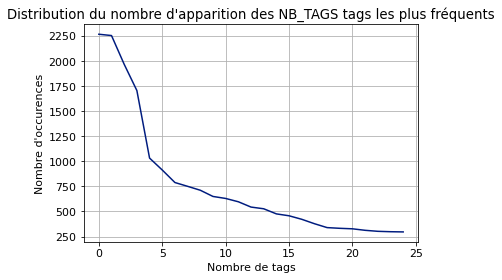

In [43]:
NB_TAGS = 25
distribution_nb_apparition_tag_questions(NB_TAGS, "Distribution du nombre d'apparition des NB_TAGS tags les plus fréquents", False)

In [44]:
words_most_common = tags_frequence.most_common(NB_TAGS)

In [45]:
fq_words_df = pd.DataFrame(words_most_common, columns = ['tags' , 'nb_tags']) 
fq_words_df.head()
SELECTED_TAGS = (fq_words_df['tags'][:NB_TAGS]).to_list()
print(SELECTED_TAGS)

['92', '38', '81', '29', '136', '162', '102', '8', '143', '131', '73', '21', '53', '82', '74', '106', '1', '96', '12', '97', '67', '55', '27', '122', '79']


In [46]:
def tags_column_processing(tags):
    new_tags = []
    tags_words = tags.split()
    for tag in tags_words:
        if (tag in SELECTED_TAGS) :
            new_tags.append(tag)   
    return new_tags

questions_df['new_tags'] = questions_df["tags"].apply(lambda text : tags_column_processing(text))

In [47]:
from sklearn.preprocessing import MultiLabelBinarizer
classes_tags = tuple(SELECTED_TAGS)
one_hot = MultiLabelBinarizer(classes = classes_tags )
#print(one_hot.fit_transform(questions_df['new_tags']))

#print(one_hot.classes_)


types_encoded = pd.DataFrame(one_hot.fit_transform(questions_df['new_tags']),columns=one_hot.classes_)
types_encoded.head()

,92,38,81,29,136,162,102,8,143,131,...,106,1,96,12,97,67,55,27,122,79
0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Concating df and types_encoded
questions_df = pd.concat([questions_df,types_encoded], axis = 1)
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,nb_tags,tags_list,new_tags,92,38,...,106,1,96,12,97,67,55,27,122,79
0,0.0,0.0,0.0,1.0,51 131 162 38,4.0,"[51, 131, 162, 38]","[131, 162, 38]",0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,131 36 81,3.0,"[131, 36, 81]","[131, 81]",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,0.0,1.0,131 101 162 92,4.0,"[131, 101, 162, 92]","[131, 162, 92]",1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.0,0.0,1.0,131 149 162 29,4.0,"[131, 149, 162, 29]","[131, 162, 29]",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.0,3.0,1.0,131 5 162 38,4.0,"[131, 5, 162, 38]","[131, 162, 38]",0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
questions_df.columns

Index(['question_id', 'bundle_id', 'correct_answer', 'part', 'tags', 'nb_tags',
       'tags_list', 'new_tags', '92', '38', '81', '29', '136', '162', '102',
       '8', '143', '131', '73', '21', '53', '82', '74', '106', '1', '96', '12',
       '97', '67', '55', '27', '122', '79'],
      dtype='object')

In [50]:
# Drop column B as it is now encoded
questions_df = questions_df.drop(['new_tags', 'tags', 'tags_list'],axis = 1)

In [51]:
questions_df = questions_df[~questions_df['part'].isna()]

In [52]:
questions_df['part'].unique()

array([1., 2., 3., 4., 5., 6., 7.])

In [53]:
questions_df['is_reading_section']= 0 
questions_df.loc[questions_df['part'] >= 5 ,'is_reading_section'] = 1

In [54]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,nb_tags,92,38,81,29,136,...,1,96,12,97,67,55,27,122,79,is_reading_section
0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2.0,2.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3.0,3.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4.0,4.0,3.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [55]:
questions_df.head(20)

,question_id,bundle_id,correct_answer,part,nb_tags,92,38,81,29,136,...,1,96,12,97,67,55,27,122,79,is_reading_section
0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2.0,2.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3.0,3.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4.0,4.0,3.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,5.0,5.0,2.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,6.0,6.0,2.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,7.0,7.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,8.0,8.0,3.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,9.0,9.0,3.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Lectures.csv

## Merge questions and train

In [56]:
train_df = pd.merge(train_df,questions_df, how='left', left_on='content_id', right_on='question_id').sort_values('row_id')


In [57]:
train_df.head()
#train_df[train_df['1'] == 1]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,1,96,12,97,67,55,27,122,79,is_reading_section
0,0,0,115,5692,0,1,3,1,25314.974609,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,56943,115,5716,0,2,2,1,37000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,118363,115,128,0,0,0,1,55000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,131167,115,7860,0,3,0,1,19000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,137965,115,7922,0,4,1,1,11000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* ### Box plot entre 2 variables : qualitatives et quantitative

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


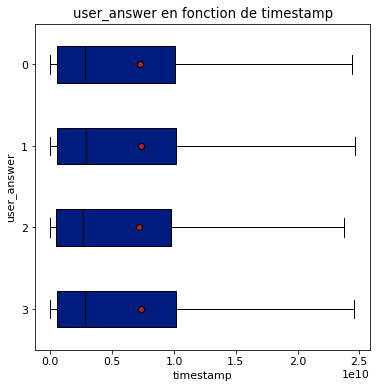

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


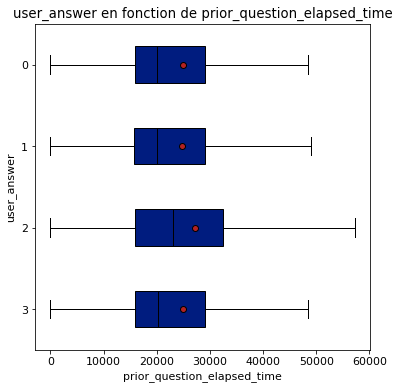

In [58]:
X = "user_answer" # qualitative
data_df = train_df[train_df['user_answer'] >=0].sort_index()


modalites = np.sort(data_df[X].unique())
modalites = modalites[::-1]

list_columns = ['timestamp', 'prior_question_elapsed_time']

for column in list_columns:
    Y = column # quantitative
    fig, ax = plt.subplots(figsize=(6, 6))
    groupes = []
    for m in modalites:
        groupes.append(data_df[(train_df[X]==m) & (~(train_df[Y].isna()))][Y])

    # Propriétés graphiques (pas très importantes)    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
    plt.title(X + ' en fonction de '+column)
    plt.ylabel(X)
    plt.xlabel(column)    
    plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

In [59]:
# Display information by user ID 
print(pd.pivot_table(train_df, index='user_id', values=['timestamp', 'prior_question_elapsed_time', 'answered_correctly'], aggfunc='mean'))

          answered_correctly  prior_question_elapsed_time     timestamp
user_id                                                                
115                 0.695652                 20050.304688  1.021248e+08
124                 0.233333                 19010.398438  3.678599e+05
2746                0.500000                 18781.498047  3.831790e+05
5382                0.632812                 35712.968750  3.801312e+08
8623                0.598214                 26079.105469  3.479882e+08
...                      ...                          ...           ...
20913319            0.560096                 27559.222656  1.000491e+09
20913864            0.333333                 18538.808594  3.227052e+05
20938253            0.575701                 22690.800781  2.468541e+08
20948951            0.607843                 19966.960938  2.236561e+09
20949024            0.312500                 32601.978516  1.052297e+07

[3824 rows x 3 columns]


# Target

In [60]:
(train_df['answered_correctly']==-1).mean()
# We should exclude information about lectures.
train_df_questions = train_df[train_df['answered_correctly']!=-1]
train_df_questions['answered_correctly'].mean()

0.6504304256664218

In [61]:
'''cids = train_df.content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()'''

'cids = train_df.content_id.value_counts()[:30]\n\nfig = plt.figure(figsize=(12,6))\nax = cids.plot.bar()\nplt.title("Thirty most used content id\'s")\nplt.xticks(rotation=90)\nax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), \',\'))) #add thousands separator\nplt.show()'

In [62]:
train_df['is_first_question'] = 0

train_df.loc[train_df['prior_question_elapsed_time'].isna(),'is_first_question'] = 1


In [63]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,96,12,97,67,55,27,122,79,is_reading_section,is_first_question
0,0,0,115,5692,0,1,3,1,25314.974609,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,1,56943,115,5716,0,2,2,1,37000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,2,118363,115,128,0,0,0,1,55000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,131167,115,7860,0,3,0,1,19000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,137965,115,7922,0,4,1,1,11000.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [64]:
user_agg = train_df.groupby('user_id')['answered_correctly'].\
                    agg(['sum', 'count']) #,'mean','median','std'])
#train_df['user_sum'] = train_df['user_id'].map(user_agg['sum']).astype('int32')
train_df['user_count'] = train_df['user_id'].map(user_agg['count']).astype('int32')
train_df['user_nb_mean'] = train_df['user_id'].map(user_agg['sum']/user_agg['count']).astype('int32')
#train_df['user_mean'] = train_df['user_id'].map(user_agg['mean']).astype('int32')
#train_df['user_median'] = train_df['user_id'].map(user_agg['median']).astype('int32')
#train_df['user_std'] = train_df['user_id'].map(user_agg['std']).astype('int32')

In [65]:
content_agg = train_df.groupby('content_id')['answered_correctly'].\
                        agg(['sum', 'count']) #'mean', 'median', 'std'
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
#train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_nb_mean'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

# Baseline

In [66]:
train_df.columns


Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'prior_had_explanation_le', 'timestamp_by_month',
       'prior_question_elapsed_time_in_hours', 'question_id', 'bundle_id',
       'correct_answer', 'part', 'nb_tags', '92', '38', '81', '29', '136',
       '162', '102', '8', '143', '131', '73', '21', '53', '82', '74', '106',
       '1', '96', '12', '97', '67', '55', '27', '122', '79',
       'is_reading_section', 'is_first_question', 'user_count', 'user_nb_mean',
       'content_count', 'content_nb_mean'],
      dtype='object')

In [67]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [68]:
train_df = train_df[train_df['answered_correctly']!= -1]
features_bsl = ['timestamp_by_month', 'nb_tags', 'is_first_question',
                'prior_had_explanation_le', 'prior_question_elapsed_time_in_hours',
                'content_id', 'content_count', 'content_nb_mean',
                'user_nb_mean', 'user_count', 'is_reading_section',
                '92', '38', '81', '29', '136',
                '162', '102', '8', '143', '131']

X = train_df[features_bsl]
X = sc.fit_transform(X)
y = train_df['answered_correctly']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [69]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [70]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [71]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [72]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [73]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=7, random_state=1, metric='None', n_jobs=4, n_estimators=200)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=1,
    verbose=True)

In [74]:
#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.7514851143810443 with params: {'colsample_bytree': 0.9080972808940212, 'min_child_samples': 343, 'min_child_weight': 0.01, 'num_leaves': 42, 'reg_alpha': 5, 'reg_lambda': 0, 'subsample': 0.863184719640143} 

In [75]:
y.describe()

count    979147.000000
mean          0.650430
std           0.476834
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: answered_correctly, dtype: float64

In [76]:
clf = lgb.LGBMClassifier(max_depth=7, 
                         random_state=1, metric='None', 
                         n_jobs=4, n_estimators=200)


params = {
    #'bagging_fraction': 0.5817242323514327,
    'feature_fraction': 0.6884588361650144,
    #'learning_rate': 0.42887924851375825, 
    'learning_rate': 0.4, 
    'max_depth': 7,
    'min_child_samples': 100, 
    'min_child_weight': 0.01,
    'min_data_in_leaf': 20, 
    'n_estimators': 200,
    'n_job': 4,
    'num_leaves': 42,
    'random_state': 1,
    'reg_alpha': 5, 
    'reg_lambda': 0,
    'subsample': 0.863184719640143
    
    
}
lgbm = LGBMClassifier( **params)

In [77]:
train_df[features_bsl].shape

(979147, 21)

In [78]:
lgbm.fit(train_df[features_bsl], y)

LGBMClassifier(feature_fraction=0.6884588361650144, learning_rate=0.4,
               max_depth=7, min_child_samples=100, min_child_weight=0.01,
               min_data_in_leaf=20, n_estimators=200, n_job=4, num_leaves=42,
               random_state=1, reg_alpha=5, reg_lambda=0,
               subsample=0.863184719640143)

In [79]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y.values, lgbm.predict_proba(train_df[features_bsl])[:,1])

0.7685089391656348

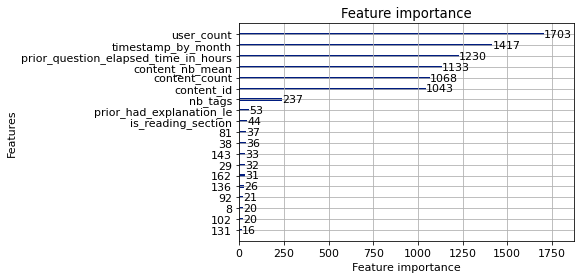

In [80]:
#displaying the most important features
lgb.plot_importance(lgbm)
plt.show()

In [81]:
import riiideducation
import pandas as pd

# You can only call make_env() once, so don't lose it!
env = riiideducation.make_env()

In [82]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


In [83]:
from collections import defaultdict
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [84]:
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    
    test_df['is_first_question'] = 0
    
    test_df.loc[test_df['prior_question_had_explanation'].isna(),'is_first_question'] = 1
    
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df.loc[test_df["prior_question_had_explanation"]== True, "prior_had_explanation_le"] = 1
    test_df.loc[test_df["prior_question_had_explanation"]== False, "prior_had_explanation_le"] = 0
    
    prior_question_elapsed_time_mean = test_df[~test_df['prior_question_elapsed_time'].isna()]['prior_question_elapsed_time'].mean()
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    
    
    test_df = pd.merge(test_df,questions_df, how='left', left_on='content_id', right_on='question_id').sort_values('row_id')
    test_df = test_df.sort_values(['user_id','timestamp'], ascending=False)
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_count'] = user_count
    test_df['user_sum'] = user_sum
    test_df['user_nb_mean'] = user_sum/user_count
    
    # New user ? Pas encore de réponses ?
    test_df['content_count'] = content_count
    test_df['content_nb_mean'] = content_sum/content_count
    
    test_df['prior_question_elapsed_time_in_hours'] = test_df['prior_question_elapsed_time']/1000/60/60
    test_df['timestamp_by_month'] = test_df['timestamp']/nbMillisecByMonth
    
    
    test_df['answered_correctly'] =  lgbm.predict(test_df[features_bsl])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
